In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import lightgbm as lgb
from sklearn.model_selection import KFold
from imblearn.metrics import  geometric_mean_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve, precision_score 
from sklearn.metrics import recall_score, average_precision_score, auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

In [2]:
missing_values = ["n/a", "na", "--", "?"]
pima_df = pd.read_csv('pima.data',na_values = missing_values)

pima_df



6  148  72  35    0  33.6  0.627  50  positive
0     1   85  66  29    0  26.6  0.351  31  negative
1     8  183  64   0    0  23.3  0.672  32  positive
2     1   89  66  23   94  28.1  0.167  21  negative
3     0  137  40  35  168  43.1  2.288  33  positive
4     5  116  74   0    0  25.6  0.201  30  negative
..   ..  ...  ..  ..  ...   ...    ...  ..       ...
762  10  101  76  48  180  32.9  0.171  63  negative
763   2  122  70  27    0  36.8  0.340  27  negative
764   5  121  72  23  112  26.2  0.245  30  negative
765   1  126  60   0    0  30.1  0.349  47  positive
766   1   93  70  31    0  30.4  0.315  23  negative

[767 rows x 9 columns]

In [3]:
pima_df.columns = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Class']
pima_df
print(pima_df['Class'].value_counts())

negative    500
positive    267
Name: Class, dtype: int64


In [4]:
pima_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               767 non-null    int64  
 1   Glucose                   767 non-null    int64  
 2   BloodPressure             767 non-null    int64  
 3   SkinThickness             767 non-null    int64  
 4   Insulin                   767 non-null    int64  
 5   BMI                       767 non-null    float64
 6   DiabetesPedigreeFunction  767 non-null    float64
 7   Age                       767 non-null    int64  
 8   Class                     767 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 54.1+ KB


Count of Non-diabetic records 500
Count of Diabetic records 267


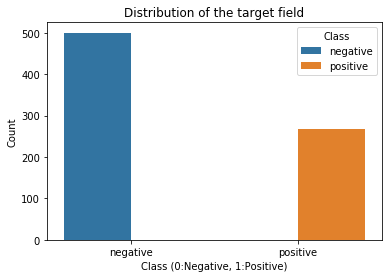

In [5]:
negative, positive = pima_df['Class'].value_counts()
print('Count of Non-diabetic records', negative)
print('Count of Diabetic records', positive)
sns.countplot(x="Class", hue="Class", data=pima_df)
plt.ylabel('Count')
plt.xlabel('Class (0:Negative, 1:Positive)')
plt.title('Distribution of the target field')
plt.show()

Count of Negative patients 500
Count of Positive patients 267


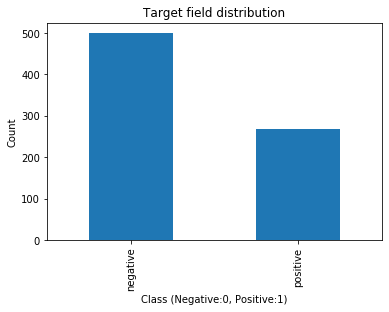

In [6]:
negative, positive = pima_df['Class'].value_counts()
print('Count of Negative patients', negative)
print('Count of Positive patients', positive)
pima_df['Class'].value_counts().plot(kind='bar', title='Target field distribution')
plt.ylabel('Count')
plt.xlabel('Class (Negative:0, Positive:1)')
plt.show()

In [7]:
#Rename categorical data in target
replace = {"Class":     {"negative": 0, "positive": 1}}
pima_df = pima_df.replace(replace)
pima_df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            1       85             66             29        0  26.6   
1            8      183             64              0        0  23.3   
2            1       89             66             23       94  28.1   
3            0      137             40             35      168  43.1   
4            5      116             74              0        0  25.6   

   DiabetesPedigreeFunction  Age  Class  
0                     0.351   31      0  
1                     0.672   32      1  
2                     0.167   21      0  
3                     2.288   33      1  
4                     0.201   30      0

In [8]:
x= pima_df.drop(['Class'], axis=1)
x
y = pima_df['Class']
print(x)


     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              1       85             66             29        0  26.6   
1              8      183             64              0        0  23.3   
2              1       89             66             23       94  28.1   
3              0      137             40             35      168  43.1   
4              5      116             74              0        0  25.6   
..           ...      ...            ...            ...      ...   ...   
762           10      101             76             48      180  32.9   
763            2      122             70             27        0  36.8   
764            5      121             72             23      112  26.2   
765            1      126             60              0        0  30.1   
766            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  
0                       0.351   31  
1                       0.672   32  


# AIS Algorithm functions

In [9]:
def initilization_of_population_featurebased(size,n_feat):
    population = []
    #chromosome = []
    for j in range(size): 
        chromosome = []    #chromosome type is list
        for i in range(n_feat):
            if i == 0:
                gene = random.randint(6, 14)
            elif i == 1:
                gene = random.randint(104, 190)
            elif i == 2:
                gene = random.randint(60, 94)
            elif i == 3:
                gene = random.randint(20, 45)
            elif i == 4:
                gene = random.randint(110, 500)
            elif i == 5:
                gene = round(random.uniform(30.1, 53))
            elif i == 6:
                gene = round(random.uniform(0.1, 1.89))
            else:
                gene =  random.randint(22, 54)
            chromosome.append(gene)
        population.append(chromosome)
    return(population)

In [10]:
def fitness_score(population,model,X_train,X_test, y_train, y_test):
    scores = []
    for chromosome in population:
        a_series = pd.Series(chromosome, index = X_train.columns)
        X_train_with_chromosome = X_train.append(a_series, ignore_index=True)
        y_train_with_chromosome = y_train.append(pd.DataFrame([1]))
        model.fit(X_train_with_chromosome,np.ravel(y_train_with_chromosome))
        predictions = model.predict(X_test)
        scores.append(f1_score(np.ravel(y_test), predictions))
    scores, population = np.array(scores), np.array(population) # list of arrays scores = [[array1],[array2]]
    inds = np.argsort(scores) #[2, 3, 1, 0] indicates that the smallest element is at index 2, the next smallest at index 3, then index 1, then index 0.
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) #list of list (converting each array such as array, array2  0 to list in sorted order)

In [11]:
def selection(pop_after_fit,n_parents):
    population_nextgen = [] #New array 
    for i in range(n_parents): 
        population_nextgen.append(pop_after_fit[i])  # append the best chromosomes as parents from results after fit function
    return population_nextgen 

In [12]:
def clone(pop_after_sel, clone_rate):
    population_next_gen_cloned = []
    population_next_gen=pop_after_sel
    for x in range(clone_rate):
            for i in range(len(population_next_gen)):
                clones = population_next_gen[i]
                population_next_gen_cloned.append(clones)
    return population_next_gen_cloned
    

In [13]:
def mutation_clone(pop_after_clone,mutation_rate):
    population_nextgen = []
    for i in range(0,len(pop_after_clone)):  #consider each chromoseome from the cross over set
        chromosome = pop_after_clone[i]  #take in sequence one after other chromosomes
        for j in range(len(chromosome)):  #with the one chromosome array
            if j == 0:  #Up to us can be anything here we see if randomly generated value < mutate
                chromosome[j] = int(chromosome[j] + (mutation_rate * 8))
            elif j== 1:
                chromosome[j] = int(chromosome[j] + (mutation_rate * 10))
            elif j== 2:
                chromosome[j] = int(chromosome[j] + (mutation_rate * 34))
            elif j== 3:
                chromosome[j] = int(chromosome[j] + (mutation_rate * 25))
            elif j== 4:
                chromosome[j] = int(chromosome[j] + (mutation_rate * 50))
            elif j== 5:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate * 12.9)),1)
            elif j== 6:
                chromosome[j] = round(float(chromosome[j] + (mutation_rate * 1.2)),3)
            else:
                chromosome[j] = int(chromosome[j] + (mutation_rate * 32))
        population_nextgen.append(chromosome)  #append all the changed ones to next_gen
    
    return population_nextgen

In [14]:
def generations(size,n_feat,n_parents,mutation_rate, clone_rate,model,X_train,X_test, y_train, y_test):
    best_chromo= []
    best_score= []
    stop_condition = True
    i = 0
    fscore_counter = 0
    bestscore_counter = 0
    population_nextgen=initilization_of_population_featurebased(size,n_feat)
    print('Initial random population based on minority class features')
    print(population_nextgen)
    while stop_condition:
        print(i)
        print('--------------------------------------------------------------------------')
        scores, pop_after_fit = fitness_score(population_nextgen, model,X_train,X_test, y_train, y_test)
        print('Scores of each chromosomes in sorted order')
        print(scores)
        print('Chromosome set sorted and corresponding to scores')
        print(pop_after_fit)
        pop_after_sel = selection(pop_after_fit,n_parents)
        print('Selects the best parents to generate better chromosomes for next generation')
        print(pop_after_sel)
        print("Clone after selection based on clone_rate")
        pop_after_clone = clone(pop_after_sel, clone_rate)
        print(pop_after_clone)
        print('Mutate the cloned population')
        population_nextgen = mutation_clone(pop_after_clone,mutation_rate)
        print(population_nextgen)
        if i > 0:
             if round(best_score[-1],5) >= round(scores[0],5):
                    print("Checking if the values are degrading or equal")
                    fscore_counter = fscore_counter + 1
                    print(fscore_counter)
                    if fscore_counter == 10 :
                        print("&&&&&&&&&--------Fscore_counter is checked and near to 10--------&&&&&&&&&&&&&")
                        stop_condition = False
                        
             elif stop_condition == True:
                if round(best_score[-1],5) < round(scores[0],5):
                    print("&&&&&&&&&&&&&&-----Fscore_counter is recompiled to O-------&&&&&&&&&&&&&&&&&")
                    fscore_counter = 0
             if stop_condition == True:
                if len(best_score) > 150:
                    print("-----Length of best score is exceeded so stopping the AIS now--------")
                    stop_condition = False
             #else:
               # stop_condition = True
                    
        i = i + 1
        
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
        print('best score and chromosome')
        print(best_chromo)
        print(best_score)
        
    return best_chromo, best_score

In [15]:
def update_AIS_GeneratedSample_in_TrainSet(chromo,Initial_X_train,Initial_y_train):
    X_train = Initial_X_train
    y_train = Initial_y_train
    for best_chromo in chromo:
        X_train_bestchromo = []
        a_series = pd.Series(best_chromo, index = X_train.columns)
        X_train_bestchromo = X_train.append(a_series, ignore_index=True)
        X_train = X_train_bestchromo
        y_train_bestchromo = y_train.append(pd.DataFrame([1]))
        y_train = y_train_bestchromo
    return X_train, y_train

In [16]:
def modelling_using_AIS_SampledTrainset(AIS_X_train, AIS_y_train, AIS_X_test, AIS_y_test,classifier):
    model = classifier
    model.fit(AIS_X_train,np.ravel(AIS_y_train))
    predictions = model.predict(AIS_X_test)
    acc, recal, precis, aucroc, gmean, _val = evaluation(predictions, AIS_y_test)
    
    return acc, recal, precis, aucroc, gmean, _val
    
    

In [17]:
def evaluation(pred_values, y_test):
    
    acc = accuracy_score(np.ravel(y_test), pred_values)
    recal = recall_score(np.ravel(y_test), pred_values)
    precis = precision_score(np.ravel(y_test), pred_values)
    #val = f1_score(y_test, pred_values)
    aucroc = roc_auc_score(np.ravel(y_test), pred_values)
    _val = f1_score(np.ravel(y_test), pred_values)
    gmean = geometric_mean_score(np.ravel(y_test), pred_values)
    
    return acc, recal, precis, aucroc, gmean, _val

# AIS algorithm on Train and Test datasets function

In [18]:
def AIS_sampling_and_modelling(x,y,model,size,n_feat,n_parents,mutation_rate,clone_rate,foldvalue):
    kf = KFold(n_splits=foldvalue, shuffle = True, random_state=1)
    k = foldvalue
    acc_score = []
    recal_score = []
    pres_score = []
    _fscore = []
    aucroc_score = []
    gmean_score = []
    classifier = model
    for train_index , test_index in kf.split(x):
        print('--------------------------*****START OF FOLD*******--------------------------------------')
        X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        Initial_X_train = X_train
        Initial_y_train = y_train
        print('Population generation using {0} Classifier'.format(model))
        print('------------------******AIS STARTED****---------------------------------------------')
        chromo,score=generations(size=size,n_feat=n_feat,n_parents=n_parents,mutation_rate=mutation_rate,clone_rate=clone_rate,
                     model = model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)
        print('-----------------------***AIS ENDED****---------------------------------------------')
        X_train_AISsampled, y_train_AISsampled = update_AIS_GeneratedSample_in_TrainSet(chromo,Initial_X_train,Initial_y_train)
        print('-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------')
        acc, recal, precis, aucroc, gmean, _val = modelling_using_AIS_SampledTrainset(X_train_AISsampled, y_train_AISsampled, X_test, y_test, model)
        acc_score.append(acc)
        recal_score.append(recal)
        pres_score.append(precis)
        _fscore.append(_val)
        aucroc_score.append(aucroc)
        gmean_score.append(gmean)
        print('-------------*******CALCULATED METRICS FOR THIS FOLD***--------------')
        print('-----------------------****END OF FOLD*****------------------------------------------------')                  
    avg_acc_score = sum(acc_score)/k
    avg_recal_score = sum(recal_score)/k
    avg_precis_score = sum(pres_score)/k
    avg_f_score = sum(_fscore)/k
    avg_auc_score = sum(aucroc_score)/k
    avg_gmean_score = sum(gmean_score)/k
    print('Metrics for each fold of {0} using AIS algorithm'.format(classifier))
    print('Accuracy : {0}'.format(acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))
    print('Recall : {0}'.format(recal_score))
    print('Avg recall : {}'.format(avg_recal_score))
    print('Precision : {0}'.format(pres_score))
    print('Avg precision : {}'.format(avg_precis_score))
    print('F1_score : {0}'.format(_fscore))
    print('Avg f-score : {}'.format(avg_f_score))
    print('AUC_ROC : {0}'.format(aucroc_score))
    print('Avg AUC_ROC : {}'.format(avg_auc_score))
    print('Geometric mean : {0}'.format(gmean_score))
    print('Avg gmean : {}'.format(avg_gmean_score))
        

In [19]:
def AIS_with_resampling(x,y,model,sampler,size,n_feat,n_parents,mutation_rate,clone_rate,foldvalue):
    kf = KFold(n_splits=foldvalue, shuffle = True, random_state=1)
    k = foldvalue
    acc_score = []
    recal_score = []
    pres_score = []
    _fscore = []
    aucroc_score = []
    gmean_score = []
    classifier = model
    sampleclassifier = sampler
    for train_index , test_index in kf.split(x):
        print('--------------------------*****START OF FOLD*******--------------------------------------')
        X_train , X_test = x.iloc[train_index,:],x.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        Initial_X_train = X_train
        Initial_y_train = y_train
        print('Population generation using {0} Classifier'.format(model))
        print('------------------******AIS STARTED****---------------------------------------------')
        chromo,score=generations(size=size,n_feat=n_feat,n_parents=n_parents,mutation_rate=mutation_rate,clone_rate=clone_rate,
                     model = model,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)
        print('-----------------------***AIS ENDED****---------------------------------------------')
        X_train_AISsampled, y_train_AISsampled = update_AIS_GeneratedSample_in_TrainSet(chromo,Initial_X_train,Initial_y_train)
        print('----------------*****Applying sampling {0} technique on updated AIS train datasets******----------'.format(sampleclassifier))
        AIS_X_train_sampled, AIS_y_train_sampled = sampleclassifier.fit_resample(X_train_AISsampled, np.ravel(y_train_AISsampled))
        print('-------------------******METRICS CALCULATION FOR THIS FOLD STARTED*****--------------')
        acc, recal, precis, aucroc, gmean, _val = modelling_using_AIS_SampledTrainset(AIS_X_train_sampled, AIS_y_train_sampled, X_test, y_test, model)
        acc_score.append(acc)
        recal_score.append(recal)
        pres_score.append(precis)
        _fscore.append(_val)
        aucroc_score.append(aucroc)
        gmean_score.append(gmean)
        print('-------------*******CALCULATED METRICS FOR THIS FOLD***--------------')
        print('-----------------------****END OF FOLD*****------------------------------------------------')                  
    avg_acc_score = sum(acc_score)/k
    avg_recal_score = sum(recal_score)/k
    avg_precis_score = sum(pres_score)/k
    avg_f_score = sum(_fscore)/k
    avg_auc_score = sum(aucroc_score)/k
    avg_gmean_score = sum(gmean_score)/k
    print('Metrics for each fold of {0} using AIS algorithm'.format(classifier))
    print('Accuracy : {0}'.format(acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))
    print('Recall : {0}'.format(recal_score))
    print('Avg recall : {}'.format(avg_recal_score))
    print('Precision : {0}'.format(pres_score))
    print('Avg precision : {}'.format(avg_precis_score))
    print('F1_score : {0}'.format(_fscore))
    print('Avg f-score : {}'.format(avg_f_score))
    print('AUC_ROC : {0}'.format(aucroc_score))
    print('Avg AUC_ROC : {}'.format(avg_auc_score))
    print('Geometric mean : {0}'.format(gmean_score))
    print('Avg gmean : {}'.format(avg_gmean_score))
        

# AIS using Random Forest Classifier 

In [30]:
RandomForestModel = RandomForestClassifier(random_state = 24)
random.seed(1)

AIS_sampling_and_modelling(x,y,model = RandomForestModel,size = 10,n_feat =8 ,n_parents = 6,mutation_rate = 0.10,
                           clone_rate = 6,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using RandomForestClassifier(random_state=24) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[8, 176, 64, 28, 170, 41, 1, 46], [9, 116, 91, 20, 309, 40, 1, 22], [13, 138, 74, 38, 162, 51, 0, 23], [14, 105, 84, 41, 220, 52, 1, 36], [13, 167, 74, 31, 228, 46, 1, 40], [6, 157, 66, 25, 432, 53, 2, 29], [11, 168, 87, 36, 453, 34, 1, 53], [14, 154, 62, 35, 234, 47, 1, 33], [11, 174, 83, 22, 334, 45, 0, 32], [14, 154, 83, 35, 485, 31, 0, 47]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.5977011494252873, 0.5842696629213482, 0.5842696629213482, 0.5747126436781609, 0.5747126436781609, 0.5747126436781609, 0.5681818181818181, 0.5681818181818181, 0.5681818181818181, 0.5238095238095238]
Chromosome set sor

# Ada Boosting Classifier

In [20]:
from sklearn.ensemble import AdaBoostClassifier
AdaBoostModel = AdaBoostClassifier()

In [33]:
random.seed(1)

AIS_sampling_and_modelling(x,y,model = AdaBoostModel,size = 10,n_feat =8 ,n_parents = 6,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier() Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[8, 176, 64, 28, 170, 41, 1, 46], [9, 116, 91, 20, 309, 40, 1, 22], [13, 138, 74, 38, 162, 51, 0, 23], [14, 105, 84, 41, 220, 52, 1, 36], [13, 167, 74, 31, 228, 46, 1, 40], [6, 157, 66, 25, 432, 53, 2, 29], [11, 168, 87, 36, 453, 34, 1, 53], [14, 154, 62, 35, 234, 47, 1, 33], [11, 174, 83, 22, 334, 45, 0, 32], [14, 154, 83, 35, 485, 31, 0, 47]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.6262626262626263, 0.6105263157894736, 0.6041666666666666, 0.5979381443298969, 0.5714285714285715, 0.568421052631579, 0.568421052631579, 0.568421052631579, 0.5591397849462365, 0.5531914893617021]
Chromosome set sorted and corresponding 

# Consider this result

In [56]:
AIS_sampling_and_modelling(x,y,model = AdaBoostModel,size = 10,n_feat =8 ,n_parents = 4,mutation_rate = 0.20,
                           clone_rate = 6 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier() Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[10, 117, 76, 43, 371, 52, 2, 49], [6, 132, 61, 32, 184, 31, 2, 50], [14, 190, 87, 37, 222, 52, 1, 50], [9, 171, 61, 32, 455, 43, 1, 49], [6, 142, 68, 26, 134, 37, 2, 41], [10, 124, 86, 38, 239, 33, 1, 24], [9, 176, 89, 25, 470, 44, 0, 34], [11, 116, 73, 38, 455, 51, 1, 53], [7, 189, 84, 29, 368, 42, 1, 47], [10, 106, 70, 26, 277, 49, 1, 30]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.62, 0.6105263157894736, 0.5979381443298969, 0.5979381443298969, 0.5979381443298969, 0.5858585858585859, 0.5833333333333334, 0.577319587628866, 0.5744680851063831, 0.5652173913043478]
Chromosome set sorted and corresponding to scores
[arr

In [59]:
AIS_sampling_and_modelling(x,y,model = AdaBoostModel,size = 40,n_feat =8 ,n_parents = 20,mutation_rate = 0.10,
                           clone_rate = 5 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier() Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[13, 125, 77, 41, 378, 37, 1, 47], [14, 137, 76, 29, 117, 44, 0, 51], [13, 149, 74, 36, 337, 35, 1, 43], [8, 153, 87, 21, 438, 33, 2, 22], [10, 173, 63, 29, 303, 30, 1, 25], [9, 114, 81, 23, 453, 53, 1, 30], [10, 156, 81, 27, 123, 52, 1, 33], [14, 177, 83, 29, 260, 39, 2, 51], [7, 129, 86, 27, 421, 31, 1, 36], [9, 154, 84, 26, 428, 34, 2, 45], [6, 143, 88, 35, 197, 46, 0, 45], [12, 174, 81, 45, 372, 41, 2, 29], [10, 174, 77, 33, 115, 49, 1, 53], [7, 168, 74, 39, 492, 45, 2, 38], [12, 151, 74, 21, 162, 44, 1, 32], [8, 141, 63, 22, 221, 30, 0, 23], [7, 111, 60, 21, 385, 38, 2, 22], [14, 131, 90, 26, 246, 37, 1, 38], [9, 127, 73, 32, 140, 36, 1, 50], [6, 146, 80, 33, 171, 30, 0, 27], [8, 131, 74, 25

In [60]:
AIS_sampling_and_modelling(x,y,model = AdaBoostModel,size = 100,n_feat =8 ,n_parents = 50,mutation_rate = 0.10,
                           clone_rate = 5 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier() Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[10, 105, 67, 41, 164, 41, 0, 37], [9, 109, 74, 22, 165, 49, 0, 24], [7, 109, 76, 33, 185, 49, 0, 46], [9, 124, 94, 38, 360, 50, 2, 32], [11, 181, 85, 36, 399, 45, 1, 26], [6, 105, 79, 23, 340, 32, 2, 25], [10, 174, 79, 38, 428, 52, 2, 51], [12, 119, 74, 29, 438, 45, 0, 54], [6, 150, 88, 23, 330, 49, 0, 29], [11, 136, 73, 30, 427, 33, 0, 22], [9, 165, 82, 40, 175, 39, 1, 50], [7, 136, 63, 36, 261, 47, 1, 35], [9, 134, 84, 31, 241, 50, 2, 54], [8, 158, 90, 22, 374, 48, 1, 36], [7, 158, 85, 24, 168, 45, 2, 35], [8, 131, 77, 31, 470, 38, 1, 31], [6, 132, 76, 35, 415, 42, 1, 33], [9, 137, 74, 22, 328, 46, 1, 45], [9, 117, 60, 32, 283, 43, 1, 48], [11, 179, 76, 32, 496, 44, 1, 26], [12, 132, 90, 31, 2

# LGB classifier

In [34]:
lgbmodel = lgb.LGBMClassifier(objective='binary', random_state=0, n_jobs=-1)

In [20]:
random.seed(1)

AIS_sampling_and_modelling(x,y,model = lgbmodel,size = 10,n_feat =8 ,n_parents = 6,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using LGBMClassifier(objective='binary', random_state=0) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[8, 176, 64, 28, 170, 41, 1, 46], [9, 116, 91, 20, 309, 40, 1, 22], [13, 138, 74, 38, 162, 51, 0, 23], [14, 105, 84, 41, 220, 52, 1, 36]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.6304347826086957, 0.5319148936170214, 0.5168539325842696, 0.5057471264367817]
Chromosome set sorted and corresponding to scores
[array([  8, 176,  64,  28, 170,  41,   1,  46]), array([ 14, 105,  84,  41, 220,  52,   1,  36]), array([  9, 116,  91,  20, 309,  40,   1,  22]), array([ 13, 138,  74,  38, 162,  51,   0,  23])]
Selects the best parents to generate better chromosomes for next generation
[array([  8, 

# Below code is run on latest one and above is old one

In [35]:
random.seed(1)

AIS_sampling_and_modelling(x,y,model = lgbmodel,size = 10,n_feat =8 ,n_parents = 6,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using LGBMClassifier(objective='binary', random_state=0) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[8, 176, 64, 28, 170, 41, 1, 46], [9, 116, 91, 20, 309, 40, 1, 22], [13, 138, 74, 38, 162, 51, 0, 23], [14, 105, 84, 41, 220, 52, 1, 36], [13, 167, 74, 31, 228, 46, 1, 40], [6, 157, 66, 25, 432, 53, 2, 29], [11, 168, 87, 36, 453, 34, 1, 53], [14, 154, 62, 35, 234, 47, 1, 33], [11, 174, 83, 22, 334, 45, 0, 32], [14, 154, 83, 35, 485, 31, 0, 47]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.6304347826086957, 0.6, 0.5555555555555556, 0.5555555555555556, 0.5393258426966292, 0.5393258426966292, 0.5333333333333332, 0.5319148936170214, 0.5168539325842696, 0.5057471264367817]
Chromosome set sorted 

# Resampling

# LGB Classifier + SMOTE+ ADASYN

In [21]:
sampler_smt = SMOTE(random_state=0)
sampler_ada = ADASYN(random_state=0)

In [39]:
AIS_with_resampling(x,y,model = lgbmodel,sampler = sampler_smt,size = 10,n_feat =x.shape[1] ,n_parents = 8,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using LGBMClassifier(objective='binary', random_state=0) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[8, 144, 79, 23, 473, 42, 2, 40], [8, 130, 69, 37, 479, 31, 1, 35], [8, 142, 87, 37, 190, 31, 2, 37], [10, 112, 88, 45, 330, 43, 1, 51], [6, 154, 81, 25, 242, 41, 2, 48], [6, 111, 82, 38, 180, 44, 0, 39], [12, 176, 85, 25, 423, 32, 1, 33], [14, 144, 92, 40, 334, 51, 1, 36], [9, 144, 91, 41, 355, 52, 1, 43], [14, 182, 77, 40, 222, 31, 0, 54]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.6250000000000001, 0.6236559139784946, 0.5934065934065934, 0.5842696629213482, 0.5777777777777778, 0.5744680851063831, 0.5714285714285713, 0.5617977528089888, 0.5531914893617021, 0.5434782608695652]
Chromosome

In [40]:
AIS_with_resampling(x,y,model = lgbmodel,sampler = sampler_ada,size = 10,n_feat =x.shape[1] ,n_parents = 8,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using LGBMClassifier(objective='binary', random_state=0) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[10, 128, 88, 32, 278, 45, 2, 37], [9, 111, 71, 31, 329, 44, 1, 25], [11, 174, 86, 37, 212, 46, 1, 26], [10, 182, 64, 28, 200, 52, 0, 35], [12, 109, 63, 40, 156, 51, 1, 54], [11, 116, 80, 21, 174, 42, 1, 30], [12, 161, 61, 43, 378, 36, 1, 42], [7, 142, 62, 32, 139, 47, 1, 30], [10, 152, 67, 41, 265, 32, 2, 54], [14, 130, 81, 30, 370, 48, 2, 52]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.6, 0.5957446808510638, 0.5934065934065934, 0.5806451612903226, 0.5652173913043478, 0.5617977528089888, 0.5581395348837209, 0.5531914893617021, 0.5517241379310345, 0.5168539325842696]
Chromosome set sorted

# Random Forest +SMOTE +ADASYN

In [41]:
AIS_with_resampling(x,y,model = RandomForestModel,sampler = sampler_smt,size = 10,n_feat =x.shape[1] ,n_parents = 8,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using RandomForestClassifier(random_state=24) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[11, 183, 91, 35, 278, 33, 2, 38], [9, 115, 94, 42, 135, 43, 1, 36], [9, 168, 79, 33, 277, 30, 0, 41], [9, 114, 74, 28, 458, 44, 2, 39], [14, 152, 61, 23, 278, 38, 0, 31], [6, 148, 64, 22, 481, 53, 1, 37], [10, 171, 63, 31, 125, 32, 2, 45], [9, 116, 81, 28, 114, 42, 1, 29], [11, 186, 68, 39, 248, 39, 1, 52], [12, 172, 85, 29, 222, 45, 1, 25]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.6, 0.5977011494252873, 0.5977011494252873, 0.5747126436781609, 0.5747126436781609, 0.5747126436781609, 0.5681818181818181, 0.5681818181818181, 0.5581395348837209, 0.5517241379310345]
Chromosome set sorted and correspon

In [42]:
RandomForestModel
AIS_with_resampling(x,y,model = RandomForestModel,sampler = sampler_ada,size = 10,n_feat =x.shape[1] ,n_parents = 8,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)


--------------------------*****START OF FOLD*******--------------------------------------
Population generation using RandomForestClassifier(random_state=24) Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[9, 176, 84, 41, 356, 43, 1, 24], [8, 189, 92, 27, 320, 52, 1, 48], [12, 138, 91, 23, 452, 49, 0, 23], [13, 109, 91, 26, 311, 49, 1, 43], [9, 116, 64, 41, 492, 31, 1, 50], [9, 126, 92, 26, 370, 39, 1, 36], [11, 188, 64, 30, 136, 41, 2, 33], [8, 140, 90, 21, 408, 42, 2, 47], [7, 155, 92, 38, 440, 37, 1, 44], [13, 110, 90, 20, 328, 37, 1, 31]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.5909090909090909, 0.5813953488372093, 0.5747126436781609, 0.5747126436781609, 0.5747126436781609, 0.5681818181818181, 0.5681818181818181, 0.5681818181818181, 0.5581395348837209, 0.5517241379310345]
Chromosome set sorted

# ADA+ADASYN+AIS

In [22]:
AIS_with_resampling(x,y,model = AdaBoostModel,sampler = sampler_ada,size = 10,n_feat =x.shape[1] ,n_parents = 8,mutation_rate = 0.10,
                           clone_rate = 6 ,foldvalue = 5)

--------------------------*****START OF FOLD*******--------------------------------------
Population generation using AdaBoostClassifier() Classifier
------------------******AIS STARTED****---------------------------------------------
Initial random population based on minority class features
[[6, 147, 89, 42, 160, 43, 2, 24], [11, 116, 78, 22, 285, 43, 1, 23], [14, 130, 74, 38, 386, 32, 1, 34], [7, 136, 73, 22, 114, 36, 2, 54], [8, 148, 70, 42, 199, 33, 1, 48], [6, 159, 63, 39, 343, 48, 0, 30], [8, 135, 70, 43, 446, 35, 2, 35], [8, 156, 67, 39, 339, 43, 0, 27], [12, 124, 74, 40, 497, 49, 1, 50], [6, 178, 63, 34, 166, 44, 1, 54]]
0
--------------------------------------------------------------------------
Scores of each chromosomes in sorted order
[0.631578947368421, 0.6122448979591837, 0.6060606060606061, 0.5979381443298969, 0.5918367346938777, 0.5833333333333334, 0.577319587628866, 0.5744680851063831, 0.568421052631579, 0.5416666666666667]
Chromosome set sorted and corresponding to s